In [2]:
# Install the following packages
#%pip install bs4
#%pip install lxml
# %pip install -U sentence-transformers
# %pip install -U gensim


In [1]:
# Use only the following imports 
import pandas as pd
import matplotlib.pyplot as plt
import json
import glob
import numpy as np
import re
from bs4 import BeautifulSoup
import lxml
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer

from sentence_transformers import SentenceTransformer, util
import pandas as pd

In [4]:
DATA_FOLDER = "./data"

#### About this Assignment

For this assignment, we will investigate sentence classification of products descriptions. Our dataset consists of a database, or a training set made up of 1,018 products split across 5 categories, beverages, candy, chips, bakery, and vegetables. We also have a set of 50 products that will make up our test set.

We will start with a naive approach that assigns a product based on the prevalence of a word in each of the 5 categories. We will then use a sentence transformer to encode product names and descriptions. In order to find similar products for a given product name, we will first manually search the database of generated embeddings and subsequently use an embedding database (Facebook's FAISS). We will conclude by trying to classify products using zero-shot classification. We will conclude by assessing the performance of the three approaches on this product name classification task.

### Notes

Our dataset consists of a database, or a training set made up of 1,018 products split across 5 categories, beverages, candy, chips, bakery, and vegetables. We also have a set of 50 products that will make up our test set. We will assume that loading all the data in RAM is impractical in a real-world application. As such, we will emulate this limitation on this small dataset by not loading more than 25 products at once. Thus, none of the variables you careate should store more than 25 productsit and any solution that requires loading the data in RAM will be deemed erroneous and won't be accepted. 

You can only use the libraries that are imported in the second cell. You may need to install some or all of the packages commented out in the first cell. lastly, you will need to install the FAISS packages, installation instructions can be found [here](https://faiss.ai/). 

The data you will use as you "database" to query query sequences against is located in the the ```db_DATA_FOLDER```


In [5]:
db_DATA_FOLDER = "./data/train"

The data is stored as [`JSON lines`](https://jsonlines.org/) into five files, each named after a category. The first question is meant to help you become familiar with the data.

#### Q.1

Generate a table that contains the following fields for each category:

- `# products: The total number of products in the category.
- `avg. name length`: average length of the name field
- `avg. shortDescription length`: average length of the shortDescription field
- `avg. Price (`priceString`)": The average price in the category.
-  `# of missing shortDescription`: The number of products where the shortDescription is missing. 

Your results should be presented in a table that looks like the following (the table below was generated with `pandas`)

![](https://www.dropbox.com/s/5mh012ypkm4kipt/summary_table.png?dl=1)

**Instructions**: 

- We'll assume the data is too large to fit in RAM or to parse one line at a reasonable rate (too slow). Instead, you are required to use memory mapping (Python's mmap library) to map a batch of 25 records intro RAM  and compute each of the fields above for that batch before aggregating the results at the end as a `pandas` table.

- Note that some price strings are formatted as From $1.98.

![](https://www.dropbox.com/s/5mh012ypkm4kipt/summary_table.png?dl=1)

In [6]:
import os
import mmap
import ast
import json
import pandas as pd
from pandas import json_normalize

json_path = './data/train/beverages.jsonl'
json_file = open(json_path,"r+")
length = 0;
mapped_file = mmap.mmap(json_file.fileno(),length,access=mmap.ACCESS_WRITE) #bev
json_file.close()

json_path = './data/train/candy.jsonl'
json_file = open(json_path,"r+")
mapped_file_candy = mmap.mmap(json_file.fileno(),length,access=mmap.ACCESS_WRITE) #candy
json_file.close()


json_path = './data/train/chips.jsonl'
json_file = open(json_path,"r+")
mapped_file_chips = mmap.mmap(json_file.fileno(),length,access=mmap.ACCESS_WRITE) #chips
json_file.close()


json_path = './data/train/universal_bakery_and_bread.jsonl' 
json_file = open(json_path,"r+")
mapped_file_bakery = mmap.mmap(json_file.fileno(),length,access=mmap.ACCESS_WRITE) #bakery
json_file.close()


json_path = './data/train/vegetables.jsonl'
json_file = open(json_path,"r+")
mapped_file_veg = mmap.mmap(json_file.fileno(),length,access=mmap.ACCESS_WRITE) #vegetables
json_file.close()



In [7]:
#beverage list
bev_dict_list = list()
#candy list
candy_dict_list = list()
#chips list
chips_dict_list = list()
#bakery list
bakery_dict_list = list()
#veg list
veg_dict_list = list()

In [8]:
#dataframes for category

df_bev = pd.DataFrame(columns=['__typename','id','name', 'shortDescription','weightIncrement','numberOfReviews','averageRating','salesUnitType', 'price','priceInfo.unitPrice'])
df_can = pd.DataFrame(columns=['__typename','id','name', 'shortDescription','weightIncrement','numberOfReviews','averageRating','salesUnitType', 'price','priceInfo.unitPrice'])
df_chi = pd.DataFrame(columns=['__typename','id','name', 'shortDescription','weightIncrement','numberOfReviews','averageRating','salesUnitType', 'price','priceInfo.unitPrice'])
df_bak = pd.DataFrame(columns=['__typename','id','name', 'shortDescription','weightIncrement','numberOfReviews','averageRating','salesUnitType', 'price','priceInfo.unitPrice'])
df_veg = pd.DataFrame(columns=['__typename','id','name', 'shortDescription','weightIncrement','numberOfReviews','averageRating','salesUnitType', 'price','priceInfo.unitPrice'])


In [9]:
##working##



#return dataframe for Q2  
def batch_process(bev_dict_list,lines,category_df):    
    d_lines=lines
    dict_list = list()

    for i in range(len(d_lines)):
        try:
            a_dict=json.loads(d_lines[i])
            dict_list.append(a_dict)
        except:
            print('JSONDecodeError occured')
            print(len(d_lines))
            



    df= pd.json_normalize(dict_list) 
    
    #short_desc
    #null values to 0
    df.shortDescription = df.shortDescription.fillna('0')
    


    #rename price column
    mapping = {df.columns[df.columns.get_loc("priceInfo.priceString")]:'price'}
    df = df.rename(columns=mapping)

    df.price = [x.strip('$') for x in df.price]
    try:
        df.price = df.price.astype(float) #str->float
    except:
        print('ValueError')
        df.price =df.price.replace('[^.0-9]', '', regex=True).astype(float)
        
   

    #product count
    bev_products=df["__typename"].count()
    #print(bev_products)

    ##shortDescription (avg length)  [***]
    bev_sd_len = df['shortDescription'].str.len().mean() 
    #print(bev_sd_len)

    #name (avg length)
    bev_name_len =df['name'].str.len().mean()
    #print(bev_name_len)

    #priceInfo.priceString (avg price)
    bev_price_mean =df['price'].mean()
    #print(bev_price_mean)

    #shortDescription missing (count) [***]
    bev_sd_NA = sum(df['shortDescription']=='0') #Missing Desc = null
    #print(bev_sd_NA)


    data_dict = {'products':bev_products,'avg_name_len':bev_name_len,'avg_short_desc_len':bev_sd_len,'avg_price':bev_price_mean,'num_missing_short_desc':bev_sd_NA }
    bev_dict_list.append(data_dict)
    
    ##NEW CODE (dataframes for Q2)
    print('catagory data frame')
    return category_df.append(df,ignore_index=True)



In [10]:
batch = []
for i, line in enumerate(iter(mapped_file.readline, b"")):
        batch.append(line.decode('utf-8'))
        if i>0 and i%25 == 0:
            #print(i)
            #print('run function')
            df_bev = batch_process(bev_dict_list,batch,df_bev)
            batch=[] #reset
            #break
        

batch = []
         
for i, line in enumerate(iter(mapped_file_candy.readline, b"")):
        batch.append(line.decode('utf-8'))
        if i>0 and i%25 == 0:
            #print(i)
            #print('run function')
            df_can = batch_process(candy_dict_list,batch,df_can)
            batch=[] #reset
            #break

batch = []
         
for i, line in enumerate(iter(mapped_file_chips.readline, b"")):
        batch.append(line.decode('utf-8'))
        if i>0 and i%25 == 0:
            #print(i)
            #print('run function')
            df_chi = batch_process(chips_dict_list,batch,df_chi)
            batch=[] #reset
            #break

batch = []
         
for i, line in enumerate(iter(mapped_file_bakery.readline, b"")):
        batch.append(line.decode('utf-8'))
        if i>0 and i%25 == 0:
            #print(i)
            #print('run function')
            df_bak = batch_process(bakery_dict_list,batch,df_bak)
            batch=[] #reset
            #break

batch = []
         
for i, line in enumerate(iter(mapped_file_veg.readline, b"")):
        batch.append(line.decode('utf-8'))
        if i>0 and i%25 == 0:
            #print(i)
            #print('run function')
            df_veg = batch_process(veg_dict_list,batch,df_veg)
            batch=[] #reset
            #break
    


catagory data frame
catagory data frame
catagory data frame
catagory data frame
catagory data frame
catagory data frame
ValueError
catagory data frame
catagory data frame
catagory data frame
catagory data frame
catagory data frame
ValueError
catagory data frame
ValueError
catagory data frame
ValueError
catagory data frame
ValueError
catagory data frame
ValueError
catagory data frame
catagory data frame
catagory data frame
catagory data frame
catagory data frame
catagory data frame
ValueError
catagory data frame
catagory data frame
ValueError
catagory data frame
catagory data frame
ValueError
catagory data frame
catagory data frame
ValueError
catagory data frame
catagory data frame
catagory data frame
ValueError
catagory data frame
catagory data frame
ValueError
catagory data frame
ValueError
catagory data frame
ValueError
catagory data frame
ValueError
catagory data frame
ValueError
catagory data frame
ValueError
catagory data frame


/tmp/ipykernel_97/3389765215.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return category_df.append(df,ignore_index=True)
/tmp/ipykernel_97/3389765215.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return category_df.append(df,ignore_index=True)
/tmp/ipykernel_97/3389765215.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return category_df.append(df,ignore_index=True)
/tmp/ipykernel_97/3389765215.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return category_df.append(df,ignore_index=True)
/tmp/ipykernel_97/3389765215.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in 

ValueError
catagory data frame


/tmp/ipykernel_97/3389765215.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return category_df.append(df,ignore_index=True)


In [11]:
#dataframes for data summary
b_df = pd.DataFrame(bev_dict_list)
c_df = pd.DataFrame(candy_dict_list)
ch_df = pd.DataFrame(chips_dict_list)
ba_df = pd.DataFrame(bakery_dict_list)
v_df = pd.DataFrame(veg_dict_list)


In [12]:
summary_dict_list = list()
    
def data_calc(df, summary_dict_list):    
    #product sum
    products=df['products'].sum()
    #print(products)

    ##shortDescription (avg length)
    sd_len =  df['avg_short_desc_len'].mean()
    #print(sd_len)

    #name (avg length)
    name_len =df['avg_name_len'].mean()
    #print(name_len)

    #priceInfo.priceString (avg price)
    price_mean =df['avg_price'].mean()
    #print(price_mean)

    #shortDescription missing (count)
    sd_NA = df['num_missing_short_desc'].sum()
    #print(sd_NA)


    data_dict = {'products':products,'avg_name_len':name_len,'avg_short_desc_len':sd_len,'avg_price':price_mean,'num_missing_short_desc':sd_NA }
    summary_dict_list.append(data_dict)

data_calc(b_df,summary_dict_list) 
data_calc(c_df,summary_dict_list)   
data_calc(ch_df,summary_dict_list) 
data_calc(ba_df,summary_dict_list)
data_calc(v_df,summary_dict_list) 




In [13]:
final_df = pd.DataFrame(summary_dict_list)

index_label_map = {0:'Beverages', 1:'Candy', 2:'Chips', 3:'Bakery',4:'Vegetables'}
final_df = final_df.rename(index=index_label_map)

final_df

,products,avg_name_len,avg_short_desc_len,avg_price,num_missing_short_desc
Beverages,401,69.438750,103.549231,12.744502,83
Candy,76,63.893333,116.931795,4.375379,0
Chips,126,55.017538,114.228308,8.239508,10
Bakery,326,60.076450,122.727101,18.141675,13
Vegetables,51,39.076154,127.610000,9.612262,0


#### Q.2

Plot the frequency of the ten words most relevant to each category based on the TF-IDF score. To do so, you will need to concatenate the name and short description of all the products in a category. Because the fields may be highly redundant, we will only consider one word per field. For instance, one of the products in the candy category has the following name and shortDescription.

```

name = "Haribo Twin Snakes Sweet And Sour Gummy Candy, 4Oz"

shortDescription = "<li>Twin Snakes 4oz</li><li>Twin Snakes 4oz</li>"

```

After dereplicating the words, the contribution of this product to the candy text will be the following:

```

[Gummy, Snakes, Sour, Candy, Twin, Haribo, Sweet]

```

The list assumes you have removed stop words, HTML tags such as li> and /li> as well as irrelevant words like Oz, once, fl, fo (for fluid once), ct (for count), bags, etc. Unlike stop words, which are relatively easy to get rid of, handling irrelevant words is tricky and involves iteratively 1- running TF-IDF, 2- manually adding words you think are irrelevant to a list (call it `irrelevant_words`) you can screen against, and repeating steps 1 and 2 until you are satisfied with the results.

Here, it is up to you to use your judgment to determine what is irrelevant. The snippet below shows how you can use BeautifuylSoup to remove HTML tags from a string.

```python

html_str = "<li>One Kinder Joy egg</li><li>The perfect Easter treat</li><li>Great Easter basket stuffer</li>"

soup = BeautifulSoup(html_str, "lxml")

soup.getText(separator=u' ')

```

This snippet demonstrates how you can remove stopwords from strings using the `gensim` library.
 

```python
from gensim.parsing.preprocessing import remove_stopwords
text = "This delicious Werther's Original is a classic. It's just irresistible"
filtered_sentence = remove_stopwords()
print(filtered_sentence)
```

Create a new file where each line contains a product's name or description after removing stop words and HTML tags. Calle that file ` clean_text_candy `.  Again, you need to process the data in batches or 25 items. The presence of irrelevant words isn't a concern yet. Make sure you inspect the resulting text. 

In [14]:
# before html clean
df_can.shortDescription[:5]

0    <li style="color: rgb(0, 0, 0); font-family: b...
1    <li>(1) 1 oz pack of Tic Tac fresh breath mint...
2    <li>1 dispenser and 1 blister pack of candy</l...
3                <li>18 MARS Chocolate Candy Bars</li>
4        <li>220 calories per pack</li><li>Kosher</li>
Name: shortDescription, dtype: object

In [15]:

# def html_cleanup(x):
#     import re
#     x=x.strip('\n')
#     clean = re.compile('<.*?>')
#     return re.sub(clean, '', x)

def html_cleanup(x):
    import re
    x=x.strip('\n')
    clean = re.compile('<.*?>') #html
    clean_2 = re.sub(clean, ' ', x)
    return re.sub(r'[^A-Za-z &]+', ' ', clean_2) #remove numbers and symbols


In [16]:
#sd = "<li>Twin Snakes 4oz</li><li>Twin Snakes (4oz)</li>"
#print(html_cleanup(sd))


In [17]:
#short description html clean up
df_bev.shortDescription = df_bev.shortDescription.apply(lambda x: html_cleanup(x))
df_can.shortDescription = df_can.shortDescription.apply(lambda x: html_cleanup(x))
df_chi.shortDescription = df_chi.shortDescription.apply(lambda x: html_cleanup(x))
df_bak.shortDescription = df_bak.shortDescription.apply(lambda x: html_cleanup(x))
df_veg.shortDescription = df_veg.shortDescription.apply(lambda x: html_cleanup(x))



In [18]:
#/n and html tags removed
df_can.shortDescription[:5]

0                          Contains one     Ounce bag 
1         oz pack of Tic Tac fresh breath mints  Fr...
2       dispenser and   blister pack of candy  Prov...
3                           MARS Chocolate Candy Bars 
4                           calories per pack  Kosher 
Name: shortDescription, dtype: object

In [19]:
# #catagory dataframes view
# df_bev
#df_can
# df_chi
# df_bak
# df_veg 

In [20]:
def df_to_clean(df_cat):
    df_to_clean = pd.DataFrame() #empty dataframe
    df_to_clean = df_to_clean.append(df_cat["name"] + df_cat["shortDescription"].astype(str), ignore_index=True)
    df_to_clean=df_to_clean.transpose()
    col_label_map = {0:'data'}
    df_to_clean = df_to_clean.rename(columns=col_label_map)
    return df_to_clean

new_df = df_to_clean(df_can)
new_df[:5]


/tmp/ipykernel_97/672422558.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_to_clean = df_to_clean.append(df_cat["name"] + df_cat["shortDescription"].astype(str), ignore_index=True)


,data
0,"REESE'S, THiNS Dark Chocolate Peanut Butter Cu..."
1,"Tic Tac, Freshmint Breath Mints, On-the-Go Ref..."
2,"PEZ Star Wars Candy & Dispenser, 2 pc dispen..."
3,"3 Musketeers Candy Milk Chocolate Bar, Full Si..."
4,"Dove Candy Milk Chocolate Bar, Full Size - 1.4..."


In [21]:
#clean candy and concat name+shortDesription

df_to_clean_candy = pd.DataFrame() #empty dataframe
df_to_clean_candy = df_to_clean_candy.append(df_can["name"] + df_can["shortDescription"].astype(str), ignore_index=True)
df_to_clean_candy=df_to_clean_candy.transpose()
col_label_map = {0:'data'}
df_to_clean_candy = df_to_clean_candy.rename(columns=col_label_map)
df_to_clean_candy[:5]

/tmp/ipykernel_97/4067091403.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_to_clean_candy = df_to_clean_candy.append(df_can["name"] + df_can["shortDescription"].astype(str), ignore_index=True)


,data
0,"REESE'S, THiNS Dark Chocolate Peanut Butter Cu..."
1,"Tic Tac, Freshmint Breath Mints, On-the-Go Ref..."
2,"PEZ Star Wars Candy & Dispenser, 2 pc dispen..."
3,"3 Musketeers Candy Milk Chocolate Bar, Full Si..."
4,"Dove Candy Milk Chocolate Bar, Full Size - 1.4..."


In [22]:
from gensim.parsing.preprocessing import remove_stopwords
#remove stop words and symbols and numbers
text = "This delicious Werther's Original is a classic. It's each just irresistible"
text_2 = "Tic Tac, Freshmint Breath Mints, On-the-Go Refreshment, Great Halloween Party Favors, 1oz(1) 1 oz pack Tic Tac fresh breath mintsFreshmint (each pack contains 60 mints) each"

def stop_words(text):
    from gensim.parsing.preprocessing import remove_stopwords
    clean = re.sub(r'[^A-Za-z &]+', ' ', text)
    return remove_stopwords(clean)

#print(stop_words(text))
#print(stop_words(text_2))


In [23]:
df_to_clean_candy.data = df_to_clean_candy.data.apply(lambda x : stop_words(x))

In [24]:
df_to_clean_candy.data[:5]
df_to_clean_candy.data[0]

print(len(df_to_clean_candy))

76


In [25]:
#write to file
#CE note changed [] to list()

batch = list()
with open('clean_text_candy', 'a') as file:
    for i in range(len(df_to_clean_candy)):
        batch.append((df_to_clean_candy.data[i])) #batch.append(set(df_to_clean_candy.data[i]))  <-- try if need to remove duplicates here
        batch.append('\n') #<--delimiter
        if i>0 and i%25 == 0:
            file.writelines(batch)
            print(batch)
            print(i)
            batch=list()
            
        if i == len(df_to_clean_candy)-1:
            print('end of df')
        
            
    file.close
    pass




['REESE S THiNS Dark Chocolate Peanut Butter Cups Candy Individually Wrapped oz Bag Contains Ounce bag', '\n', 'Tic Tac Freshmint Breath Mints On Go Refreshment Great Halloween Party Favors oz oz pack Tic Tac fresh breath mints Freshmint pack contains mints', '\n', 'PEZ Star Wars Candy & Dispenser pc dispenser blister pack candy Provides variety assortment Star Wars characters', '\n', 'Musketeers Candy Milk Chocolate Bar Full Size oz MARS Chocolate Candy Bars', '\n', 'Dove Candy Milk Chocolate Bar Full Size oz Bar calories pack Kosher', '\n', 'Baby Ruth Bar Improved Recipe Dry Roasted Peanuts ounces A hearty candy bar great American taste Nothing works like nutty chewy taste BABY RUTH', '\n', 'Butterfinger Chocolatey Peanut Buttery Individually Wrapped Full Size Candy Bar Great Halloween Candy oz BUTTERFINGER BARS Each Butterfinger Share Pack contains candy bars', '\n', 'Hershey s Kisses Milk Chocolate Candy Individually Wrapped oz Bag Bite sized gift wrapped gems creamy smooth chocola

#### Q.3 

After inspecting the processed text from products in the candy section, you'll see that simply removing stop leaves out many irrelevant words, such as demonstrations (e.g., "this") or contracted possessive determiners (e.g., `It's`), etc... Such words are not very useful when describing candy. Perhaps sticking to nouns, proper nouns, and adjectives would suffice. For example, if we only retain the nouns, proper nouns, and adjectives in the following sentence:

`This delicious Werther's Original is a classic. It's just irresistible"`

Results in the following words, which are characteristic of candy.

`['delicious', 'werther', 'original', 'classic', 'irresistible']`


Use HuggingFace's default part of speech (pos) tagger, a variant of the token classification task, to identify and extract only nouns (e.g., hazelnut cream), proper nouns (e.g., Hershey), and adjectives (e.g. velvety). 



https://huggingface.co/tasks/token-classification

Here I suggest you use the model vblagoje/bert-english-uncased-finetuned-pos

A definition of the various predicted token symbols can be found here:

https://huggingface.co/flair/upos-multi

Try you pos tagger on the following sentence:

```
Kinder Bueno, Milk Chocolate and Hazelnut Cream, 4 Individually Wrapped Chocolate Bars, .75 oz each
```



In [3]:
from transformers import pipeline

#tags to ignore
#tags in https://huggingface.co/docs/transformers/v4.24.0/en/main_classes/pipelines#transformers.TokenClassificationPipeline
tags = ['ADP','ADV','AUX','CCONJ','DET','INTJ','NUM','PART','PRON','PUNCT','SCONJ','SYM','VERB','X']
classifier = pipeline("token-classification", model = "vblagoje/bert-english-uncased-finetuned-pos", ignore_labels = tags)

#classifier = pipeline("token-classification", model = "vblagoje/bert-english-uncased-finetuned-pos")
line_pos = classifier("Kinder Bueno, Milk Chocolate and Hazelnut Cream, 4 Individually Wrapped Chocolate Bars, .75 oz each")



In [27]:
print(type(classifier))
print(type(line_pos))
print(line_pos)

string_list = []
string = ' '

def process_line(line_pos):
    string_list = []
    string = ''
    for idx, pos in enumerate (iter(line_pos)):
        #print(line_pos[idx])
        string_list.append(line_pos[idx]['word'])
        string_list.append(' ')
       

    return string.join(string_list) #flatten list to write out to file writelines()

POS_line =  process_line(line_pos)

print(POS_line)


<class 'transformers.pipelines.token_classification.TokenClassificationPipeline'>
<class 'list'>
[{'entity': 'PROPN', 'score': 0.9668451, 'index': 1, 'word': 'kind', 'start': 0, 'end': 4}, {'entity': 'PROPN', 'score': 0.98857343, 'index': 2, 'word': '##er', 'start': 4, 'end': 6}, {'entity': 'PROPN', 'score': 0.99442106, 'index': 3, 'word': 'bu', 'start': 7, 'end': 9}, {'entity': 'PROPN', 'score': 0.994132, 'index': 4, 'word': '##eno', 'start': 9, 'end': 12}, {'entity': 'NOUN', 'score': 0.9889709, 'index': 6, 'word': 'milk', 'start': 14, 'end': 18}, {'entity': 'NOUN', 'score': 0.990171, 'index': 7, 'word': 'chocolate', 'start': 19, 'end': 28}, {'entity': 'NOUN', 'score': 0.9902362, 'index': 9, 'word': 'hazel', 'start': 33, 'end': 38}, {'entity': 'NOUN', 'score': 0.9922134, 'index': 10, 'word': '##nut', 'start': 38, 'end': 41}, {'entity': 'NOUN', 'score': 0.98553395, 'index': 11, 'word': 'cream', 'start': 42, 'end': 47}, {'entity': 'NOUN', 'score': 0.9964302, 'index': 16, 'word': 'chocol

#### Q.4

Process the file `clean_text_candy`  by feeding batches or 25 items to your POS tagger. Each line of the file should contain only adjectives, nouns, and proper nouns resulting from processing a name or a short product description.

In [28]:
import os
import mmap

cleaned = 'clean_text_candy'
cleaned_file = open(cleaned,"r+")
length = 0;
mapped_file_candy = mmap.mmap(cleaned_file.fileno(),length,access=mmap.ACCESS_WRITE) #candy
cleaned_file.close()

# REMOVE BREAK #

In [29]:
#read in from clean_text_candy -- using mmap  and batches
# write out (to delete old data to the same file; then append (see if this works or just create clean_candy_outfile
#print ('run this cell')
batch = list()
string_list = []

with open('clean_text_candy_out','a') as file:
    for i, line in enumerate(iter(mapped_file_candy.readline, b"")):
        #print('here')
        line_pos = classifier(line.decode('utf-8'))
        POS_line =  process_line(line_pos)
        batch.append(POS_line)
        #batch.append('\n') #<--delimiter (removed)

        if i>0 and i%25 == 0:
            #print('in if here')
            file.writelines(batch)
            #file.writelines(['hello','there'])
            print('batch written')
            batch=list()
            print('batch cleared')
            break

file.close()      
        
        

# batch = list()
# with open('clean_text_candy', 'a') as file:
#     for i in range(len(df_to_clean_candy)):
#         batch.append((df_to_clean_candy.data[i])) #batch.append(set(df_to_clean_candy.data[i]))  <-- try if need to remove duplicates here
#         batch.append('\n') #<--delimiter
#         if i>0 and i%25 == 0:
#             file.writelines(batch)
#             print(batch)
#             print(i)
#             batch=list()
            
#         if i == len(df_to_clean_candy)-1:
#             print('end of df')
        
            
#     file.close
#     pass



# batch = []

# with open('clean_text_candy_out', 'a') as file:
#     for i, line in enumerate(iter(mapped_file_candy.readline, b"")):
#         #line_pos = classifier(line)
#         print(line)
#         batch.append(line_pos)
#         if i>0 and i%25 == 0:
#             file.writelines(batch)
#             batch=[] #reset
#             #break






batch written
batch cleared


#### Q. 5 


Repeat the process for each of the other 4 categories. At the end of this stage you should have 5 files, `clean_text_beverages`, `clean_text_candy`, `clean_text_chips`, `clean_text_bakery`, `clean_text_vegetables`. 



In [30]:
#process
new_df_bev = df_to_clean(df_bev)
new_df_chi = df_to_clean(df_chi)
new_df_bak = df_to_clean(df_bak)
new_df_veg = df_to_clean(df_veg)


#remove stop_words
new_df_bev.data = new_df_bev.data.apply(lambda x : stop_words(x))
new_df_chi.data = new_df_chi.data.apply(lambda x : stop_words(x))
new_df_bak.data = new_df_bak.data.apply(lambda x : stop_words(x))
new_df_veg.data = new_df_veg.data.apply(lambda x : stop_words(x))


/tmp/ipykernel_97/672422558.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_to_clean = df_to_clean.append(df_cat["name"] + df_cat["shortDescription"].astype(str), ignore_index=True)
/tmp/ipykernel_97/672422558.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_to_clean = df_to_clean.append(df_cat["name"] + df_cat["shortDescription"].astype(str), ignore_index=True)
/tmp/ipykernel_97/672422558.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_to_clean = df_to_clean.append(df_cat["name"] + df_cat["shortDescription"].astype(str), ignore_index=True)
/tmp/ipykernel_97/672422558.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

In [31]:
#write out
batch = list()
with open('clean_text_bev', 'a') as file:
    for i in range(len(new_df_bev)):
        batch.append((new_df_bev.data[i])) 
        batch.append('\n') #<--delimiter
        if i>0 and i%25 == 0:
            file.writelines(batch)
            #print(batch)
            #print(i)
            batch=list()
            
        if i == len(new_df_bev)-1:
            print('end of df')            
    file.close
    pass

batch = list()
with open('clean_text_chi', 'a') as file:
    for i in range(len(new_df_chi)):
        batch.append((new_df_chi.data[i])) 
        batch.append('\n') #<--delimiter
        if i>0 and i%25 == 0:
            file.writelines(batch)
            #print(batch)
            #print(i)
            batch=list()
            
        if i == len(new_df_chi)-1:
            print('end of df')            
    file.close
    pass

batch = list()
with open('clean_text_bak', 'a') as file:
    for i in range(len(new_df_bak)):
        batch.append((new_df_bak.data[i])) 
        batch.append('\n') #<--delimiter
        if i>0 and i%25 == 0:
            file.writelines(batch)
            #print(batch)
            #print(i)
            batch=list()
            
        if i == len(new_df_bak)-1:
            print('end of df')            
    file.close
    pass

batch = list()
with open('clean_text_veg', 'a') as file:
    for i in range(len(new_df_veg)):
        batch.append((new_df_veg.data[i])) 
        batch.append('\n') #<--delimiter
        if i>0 and i%25 == 0:
            file.writelines(batch)
            #print(batch)
            #print(i)
            batch=list()
            
        if i == len(new_df_veg)-1:
            print('end of df')            
    file.close
    pass

end of df
end of df
end of df
end of df


In [32]:
#mmap each category file

cleaned = 'clean_text_bev'
cleaned_file = open(cleaned,"r+")
length = 0;
mapped_file_bev = mmap.mmap(cleaned_file.fileno(),length,access=mmap.ACCESS_WRITE) #candy
cleaned_file.close()

cleaned = 'clean_text_chi'
cleaned_file = open(cleaned,"r+")
length = 0;
mapped_file_chi = mmap.mmap(cleaned_file.fileno(),length,access=mmap.ACCESS_WRITE) #candy
cleaned_file.close()

cleaned = 'clean_text_bak'
cleaned_file = open(cleaned,"r+")
length = 0;
mapped_file_bak = mmap.mmap(cleaned_file.fileno(),length,access=mmap.ACCESS_WRITE) #candy
cleaned_file.close()

cleaned = 'clean_text_veg'
cleaned_file = open(cleaned,"r+")
length = 0;
mapped_file_veg = mmap.mmap(cleaned_file.fileno(),length,access=mmap.ACCESS_WRITE) #candy
cleaned_file.close()

# REMOVE BREAK #

In [33]:
#write output file of POS
batch = list()
string_list = []

with open('clean_text_bev_out','a') as file:
    for i, line in enumerate(iter(mapped_file_bev.readline, b"")):
        #print('here')
        line_pos = classifier(line.decode('utf-8'))
        POS_line =  process_line(line_pos)
        batch.append(POS_line)
        #batch.append('\n') #<--delimiter

        if i>0 and i%25 == 0:
            #print('in if here')
            file.writelines(batch)
            #file.writelines(['hello','there'])
            print('BEV: batch written')
            batch=list()
            print('batch cleared')
            break

file.close()        


batch = list()
string_list = []

with open('clean_text_chi_out','a') as file:
    for i, line in enumerate(iter(mapped_file_chi.readline, b"")):
        #print('here')
        line_pos = classifier(line.decode('utf-8'))
        POS_line =  process_line(line_pos)
        batch.append(POS_line)
        #batch.append('\n') #<--delimiter

        if i>0 and i%25 == 0:
            #print('in if here')
            file.writelines(batch)
            #file.writelines(['hello','there'])
            print('CHIPS: batch written')
            batch=list()
            print('batch cleared')
            break

file.close()    

batch = list()
string_list = []

with open('clean_text_bak_out','a') as file:
    for i, line in enumerate(iter(mapped_file_bak.readline, b"")):
        #print('here')
        line_pos = classifier(line.decode('utf-8'))
        POS_line =  process_line(line_pos)
        batch.append(POS_line)
        #batch.append('\n') #<--delimiter

        if i>0 and i%25 == 0:
            #print('in if here')
            file.writelines(batch)
            #file.writelines(['hello','there'])
            print('BAKERY: batch written')
            batch=list()
            print('batch cleared')
            break

file.close()    

batch = list()
string_list = []

with open('clean_text_veg_out','a') as file:
    for i, line in enumerate(iter(mapped_file_veg.readline, b"")):
        #print('here')
        line_pos = classifier(line.decode('utf-8'))
        POS_line =  process_line(line_pos)
        batch.append(POS_line)
        #batch.append('\n') #<--delimiter

        if i>0 and i%25 == 0:
            #print('in if here')
            file.writelines(batch)
            #file.writelines(['hello','there'])
            print('VEG: batch written')
            batch=list()
            print('batch cleared')
            break

file.close()    


BEV: batch written
batch cleared
CHIPS: batch written
batch cleared
BAKERY: batch written
batch cleared
VEG: batch written
batch cleared


#### Q.6

Use `gensim` to compute the TF-IDF for each category and plot the frequency for the top 10 words in each category. Here, we're using gensim for its memory independence – `there is no need for the whole training corpus to reside fully in RAM at any one time. Can process large, web-scale corpora using data streaming.`

See the following for more information about `gensim`'s TF-IDF functionality. 

https://radimrehurek.com/gensim/models/tfidfmodel.html



In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
##per Mahdi via Slack on 11/9

In [40]:
cf = CountVectorizer()

In [41]:
def count_freq_df(file):
    x = cf.fit_transform(open(file, encoding='utf-8'))
    count_df = pd.DataFrame(x.toarray(),columns = cf.get_feature_names_out())
    count_df.rename(index ={0:'count'},inplace=True)
    count_t_df = count_df.T
    return count_t_df.nlargest(10,'count')

In [42]:
file = 'clean_text_candy_out'
c_df_candy = count_freq_df(file)
c_df_candy

,count
candy,38
chocolate,33
oz,26
bar,20
milk,18
size,16
butter,12
bars,10
peanut,10
delicious,9


In [43]:
file = 'clean_text_chi_out'
c_df_chip = count_freq_df(file)

file = 'clean_text_bev_out'
c_df_bev = count_freq_df(file)

file = 'clean_text_bak_out'
c_df_bak = count_freq_df(file)

file = 'clean_text_veg_out'
c_df_veg = count_freq_df(file)

### Plots

<AxesSubplot:title={'center':'Candy Data: Top 10 Most Frequent Terms'}, xlabel='term', ylabel='freq. count'>

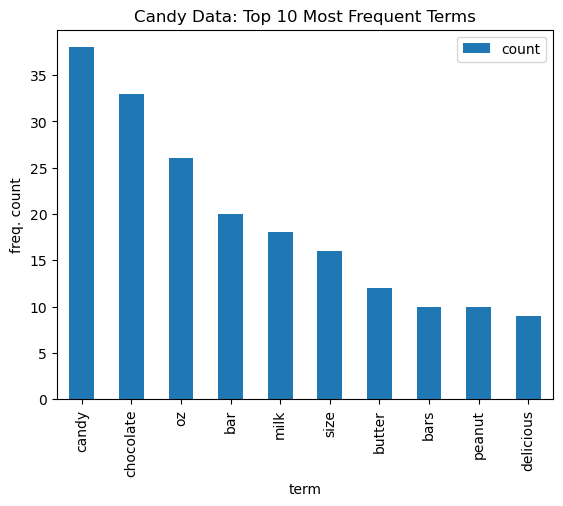

In [44]:
c_df_candy.plot(kind='bar', title = 'Candy Data: Top 10 Most Frequent Terms', xlabel = 'term', ylabel = 'freq. count')

<AxesSubplot:title={'center':'Beverage Data: Top 10 Most Frequent Terms'}, xlabel='term', ylabel='freq. count'>

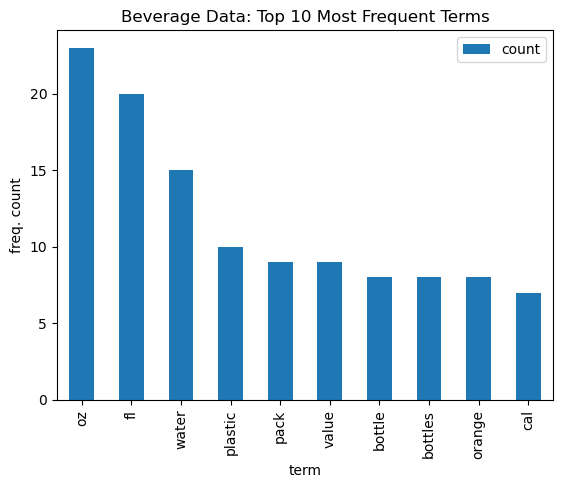

In [45]:
c_df_bev.plot(kind='bar', title = 'Beverage Data: Top 10 Most Frequent Terms', xlabel = 'term', ylabel = 'freq. count')

<AxesSubplot:title={'center':'Chip Data: Top 10 Most Frequent Terms'}, xlabel='term', ylabel='freq. count'>

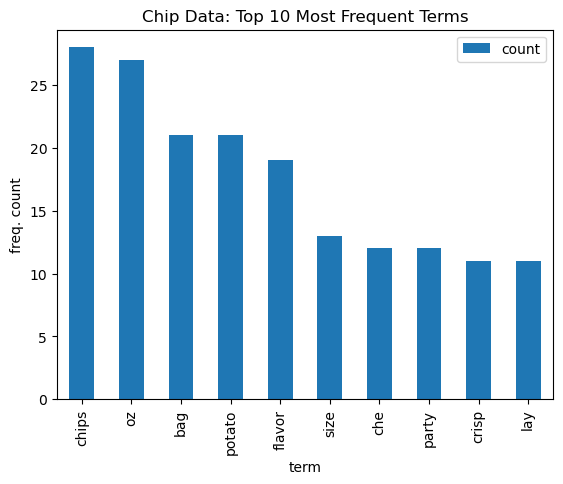

In [46]:
c_df_chip.plot(kind='bar', title = 'Chip Data: Top 10 Most Frequent Terms', xlabel = 'term', ylabel = 'freq. count')

<AxesSubplot:title={'center':'Baked-Goods Data: Top 10 Most Frequent Terms'}, xlabel='term', ylabel='freq. count'>

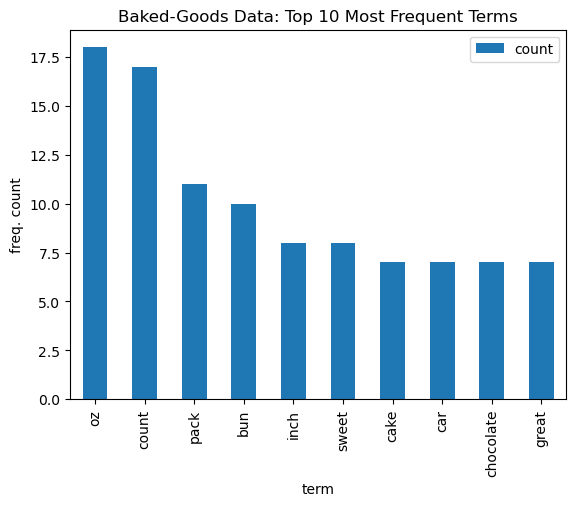

In [47]:
c_df_bak.plot(kind='bar', title = 'Baked-Goods Data: Top 10 Most Frequent Terms', xlabel = 'term', ylabel = 'freq. count')

<AxesSubplot:title={'center':'Vegetables Data: Top 10 Most Frequent Terms'}, xlabel='term', ylabel='freq. count'>

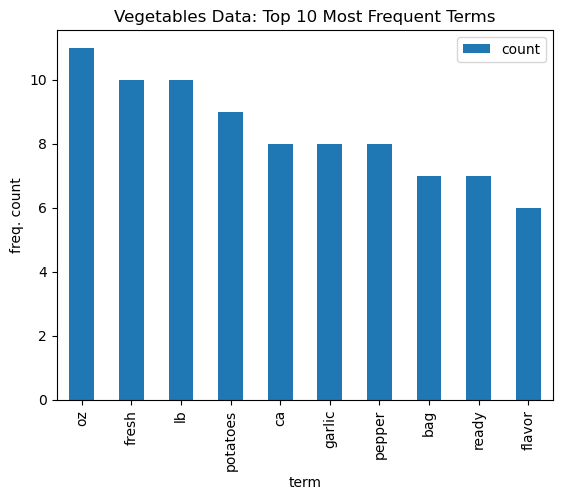

In [48]:
c_df_veg.plot(kind='bar', title = 'Vegetables Data: Top 10 Most Frequent Terms', xlabel = 'term', ylabel = 'freq. count')

<hr>

<hl>

#### Q.7

Plot the graphs (5 in total) representing the 20 most relevant keysowrds based on the TF-IDF in each category. For instance, th egraph for the `candy` category may look like the following.

![](https://www.dropbox.com/s/l8gvex0s1sgyr2l/candy_top20.png?dl=1)



In [59]:
file = 'clean_text_candy_out'
tf = TfidfVectorizer()

def tfidf_df(file):
    x = tf.fit_transform(open(file, encoding='utf-8'))
    tf_df = pd.DataFrame(x.toarray(),columns = tf.get_feature_names_out())
    tf_df.rename(index ={0:'tf-idf_score'},inplace=True)
    tf_t_df = tf_df.T
    return tf_t_df.nlargest(20,'tf-idf_score'),tf_df



In [61]:
tf_df_candy,tf_df_c = tfidf_df(file)
tf_df_candy
#tf_df_c

,tf-idf_score
candy,0.506442
chocolate,0.439805
oz,0.346513
bar,0.266548
milk,0.239893
size,0.213239
butter,0.159929
bars,0.133274
peanut,0.133274
delicious,0.119947


In [62]:
file = 'clean_text_chi_out'
tf_df_chip,tf_df_ch = tfidf_df(file)

file = 'clean_text_bev_out'
tf_df_bev,tf_df_b = tfidf_df(file)

file = 'clean_text_bak_out'
tf_df_bak,tf_df_bk = tfidf_df(file)

file = 'clean_text_veg_out'
tf_df_veg,tf_df_v = tfidf_df(file)



### Plots

<AxesSubplot:title={'center':'Candy Data: Top 20 Most Relevant Terms'}, xlabel='term', ylabel='tf-idf score'>

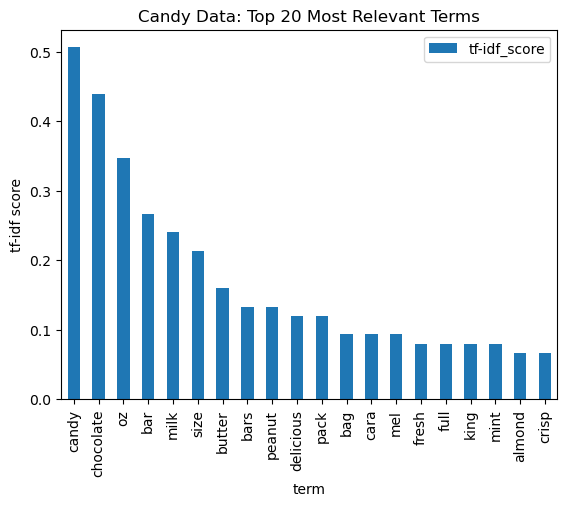

In [52]:
tf_df_candy.plot(kind='bar', title = 'Candy Data: Top 20 Most Relevant Terms', xlabel = 'term', ylabel = 'tf-idf score')

<AxesSubplot:title={'center':'Beverage Data: Top 20 Most Relevant Terms'}, xlabel='term', ylabel='tf-idf score'>

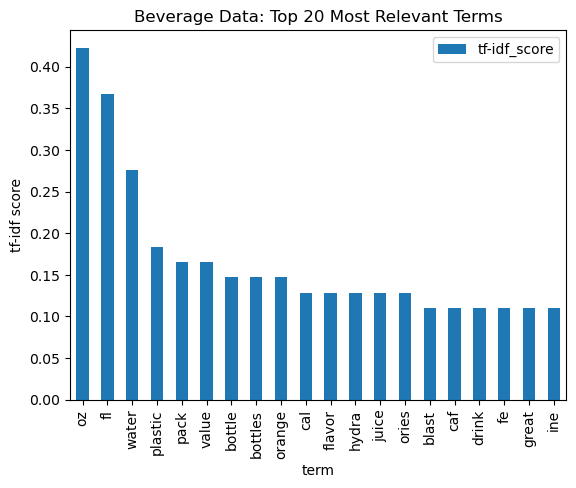

In [53]:
tf_df_bev.plot(kind='bar', title = 'Beverage Data: Top 20 Most Relevant Terms', xlabel = 'term', ylabel = 'tf-idf score')

<AxesSubplot:title={'center':'Chip Data: Top 20 Most Relevant Terms'}, xlabel='term', ylabel='tf-idf score'>

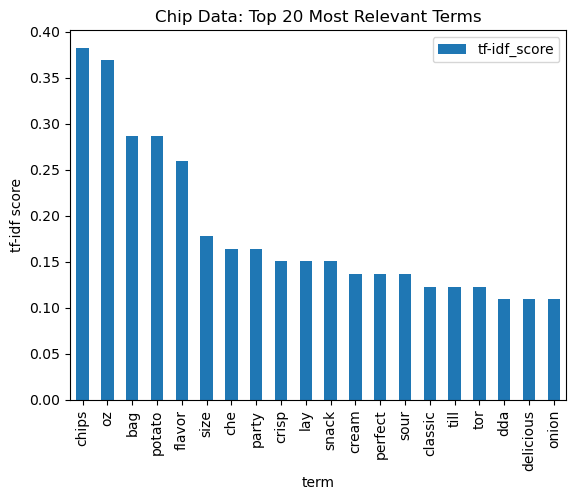

In [54]:
tf_df_chip.plot(kind='bar', title = 'Chip Data: Top 20 Most Relevant Terms', xlabel = 'term', ylabel = 'tf-idf score')

<AxesSubplot:title={'center':'Vegetable Data: Top 20 Most Relevant Terms'}, xlabel='term', ylabel='tf-idf score'>

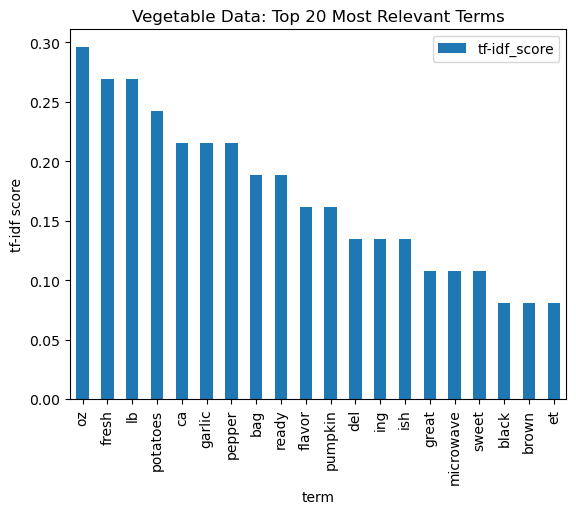

In [55]:
tf_df_veg.plot(kind='bar', title = 'Vegetable Data: Top 20 Most Relevant Terms', xlabel = 'term', ylabel = 'tf-idf score')


### K-nearest Neighbor classification

The following section will help you sort product names into one of five categories using a naive approach. In essence, the approach assigns a product name to the category with which it shares the most words, weighted by the TF-IDF.

Here, we will be using the queries in the file `test_names.tsv`(tab-delimited format). This file contains the true labels, which we will use to measure our approach's accuracy.



#### Q.8

Write a function that takes a name and computes the sum of TF-IDF values for all its words in each of the categories. For exmaple, if a product name is "Small World Chips", and the TF-IDF for the words ["Small", "World", "Chips"] are [0.1, 0.002, 0.9] and [0.8, .0002, 0.002] for the chips and candy categories, the the function would return a dictionary with the follwing: `{"candy": 0.8022, "chips": 1.002}`. Call you function `sum_tf_ids`.


Note that for each product query, you simply need to split the sequence into words and take care in removing apostrophes and punctuation and converting the words into an appropriate case. You do not need to remove stop words and words that are not relevant as those will not match against words in the categories. 

In [56]:
#handle phrase
phrase = "Baby Bottle Pop Original Candy% Lollipops with Dipping's Powder, Assorted Flavors, 1.1 oz"


def handle_phrase(phrase):
    parse_phrase = re.sub(r'[^\w ]', '', phrase) #remove punctuations
    return parse_phrase.lower().split(' ') #return phrase lise

#phrase_list = handle_phrase(phrase)
#print(phrase_list)

In [ ]:
# # temp for function build/testing only
# tf_df_chip = pd.DataFrame()
# tf_df_bev = pd.DataFrame()
# tf_df_bak = pd.DataFrame()
# tf_df_veg = pd.DataFrame()

In [63]:
#returns dict of score for each catagory
c = tf_df_c
ch = tf_df_ch
b = tf_df_b
ba = tf_df_bk
v = tf_df_v

def sum_tfidfs(phrase_list,c,ch,b,ba,v):
    total_candy_score = 0
    total_chip_score = 0
    total_bev_score = 0
    total_bak_score = 0
    total_veg_score = 0

    #test_sum = 0
    #txt = 'Candy Score: {score: .4f} '
    
    for word in phrase_list:
        #print(word)

        try:
            #print(txt.format(score = tf_df_candy[word].iat[0] ))
            total_candy_score = total_candy_score + c[word].iat[0]
            total_chip_score = total_chip_score + ch[word].iat[0]
            total_bev_score = total_bev_score + b[word].iat[0]
            total_bak_score = total_bak_score + ba[word].iat[0]
            total_veg_score = total_veg_score + v[word].iat[0]
        except:
            #print('Key Error') #values not in category
            pass
            

    # print('Total Candy Score: ')
    # print(total_candy_score)
    # print(total_chip_score)
    # print(total_bev_score)
    # print(total_bak_score)
    # print(total_veg_score)
    
    return {'candy': total_candy_score,'chip': total_chip_score,'bev': total_bev_score,'bakery': total_bak_score, 'veg': total_veg_score }
    
sum_tfidfs(handle_phrase(phrase),c,ch,b,ba,v) #nested function works

{'candy': 0.9195913835019403,
 'chip': 0.4098834957880957,
 'bev': 0.4594315386833094,
 'bakery': 0.4445004445006668,
 'veg': 0.29611004613199104}

#### Q.9

You can test your function by using the following sentence. The sum of TF-IDF values should be higher for candy and beverages than for vegetables.

```
"Baby Bottle Pop Original Candy Lollipops with Dipping Powder, Assorted Flavors, 1.1 oz"
```

In [64]:
phrase = "Baby Bottle Pop Original Candy Lollipops with Dipping Powder, Assorted Flavors, 1.1 oz"
sum_tfidfs(handle_phrase(phrase),c,ch,b,ba,v)


{'candy': 0.9195913835019403,
 'chip': 0.4098834957880957,
 'bev': 0.4594315386833094,
 'bakery': 0.4445004445006668,
 'veg': 0.29611004613199104}

#### Q.10

Repeat the process above for each of the products in the test folder. For each product name (line in the file `test_names.tsv`), use the label associated with largest `TF-IDF` sum value returned by `sum_tf_ids` function as an indicator for predicted class. How many correction predictions did this naive approach make?

In [65]:
column_names=['product','category']
test_df = pd.read_csv('data/tests/test_names.tsv', sep='\t', header = None, names = column_names)
test_df

,product,category
0,Laodicea Roasted Peppers with Garlic,vegetables
1,"Louisiana Pepper Exchange, Cayenne Pepper Pure...",vegetables
2,Great Value Creme Filled Swiss Rolls Snack Cak...,universal bakery and bread
3,Lay's Flamin' Hot Dill Pickle Flavored Potato ...,chips
4,"Lay's Potato Chips, Lightly Salted Classic Fla...",chips
5,"Schar Gluten Free Hamburger Buns, 10.6 Oz, 4-C...",universal bakery and bread
6,Dehydrated Dried Red and Green Bell Peppers Mi...,vegetables
7,Dehydrated Dried Green Bell Pepper by It's Del...,vegetables
8,Juicy Drop Pop Sweet Lollipops Candy with Sour...,candy
9,Popcorners White Cheddar Gluten Free Popped Co...,chips


In [66]:
test_df['tfidf_category']= test_df.apply(lambda row: max(sum_tfidfs(handle_phrase(row['product']),c,ch,b,ba,v), key=sum_tfidfs(handle_phrase(row['product']),c,ch,b,ba,v).get),axis=1)
test_df

,product,category,tfidf_category
0,Laodicea Roasted Peppers with Garlic,vegetables,candy
1,"Louisiana Pepper Exchange, Cayenne Pepper Pure...",vegetables,bev
2,Great Value Creme Filled Swiss Rolls Snack Cak...,universal bakery and bread,chip
3,Lay's Flamin' Hot Dill Pickle Flavored Potato ...,chips,chip
4,"Lay's Potato Chips, Lightly Salted Classic Fla...",chips,chip
5,"Schar Gluten Free Hamburger Buns, 10.6 Oz, 4-C...",universal bakery and bread,bev
6,Dehydrated Dried Red and Green Bell Peppers Mi...,vegetables,chip
7,Dehydrated Dried Green Bell Pepper by It's Del...,vegetables,chip
8,Juicy Drop Pop Sweet Lollipops Candy with Sour...,candy,candy
9,Popcorners White Cheddar Gluten Free Popped Co...,chips,chip


#### Q.11

Did the model properly classify the following product title?
`Jumbo Push Pop, Assorted Flavor Spring Lollipop, 1.06oz candy`

Explain why it did or didn't.


In [67]:
phrase = 'Jumbo Push Pop, Assorted Flavor Spring Lollipop, 1.06oz candy'

output_dict = sum_tfidfs(handle_phrase(phrase),c,ch,b,ba,v)
print(output_dict)

max_value = max(output_dict, key=output_dict.get)
print(max_value)


{'candy': 0.5197690428489228, 'chip': 0.25959288066579395, 'bev': 0.12864083083132663, 'bakery': 0.04233337566673017, 'veg': 0.16151457061744964}
candy


#### Answer:
The model correctly identified the `Jumbo Push Pop, Assorted Flavor Spring Lollipop, 1.06oz candy` as candy. Terms like `candy` and `lollipop` most likely accounted for the high `candy` tfidf summation; these words and others are unique to candy are least likely to appear in the other catagories. `chips` ranked second, likely due to the terms `jumbo`,`flavor`.

In [68]:
#another test
phrase = 'Schar Gluten Free Hamburger Buns,'

output_dict = sum_tfidfs(handle_phrase(phrase),c,ch,b,ba,v)
print(output_dict)

max_value = max(output_dict, key=output_dict.get)
print(max_value)


{'candy': 0.03998223406530175, 'chip': 0.013662783192936522, 'bev': 0.0735090461893295, 'bakery': 0.06350006350009525, 'veg': 0.05383819020581655}
bev


However, the model misidentified the `Schar Gluten Free Hamburger Buns` as a primarily as a beverage while bakery ranked second. 

### Part 2: Using Sentence Embeddings

Here, we will generate embeddings for the product names and descriptions using Sentence Transformers which we will use to find products in the training data with the most similar name or description to some input product name. If you haven't already done so, install the Sentence Transformers library (see the first cell of this notebook). Run the following line to instantiate the `SentenceTransformer` using Microsoft’s `MPNet` transformer. 

In [69]:
model = SentenceTransformer('all-mpnet-base-v2')

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

#### Q.12

Use the model above to compute the embedding for the following product description:

```   

'Kinder Bueno, Milk Chocolate and Hazelnut Cream, 4 Individually Wrapped Chocolate Bars, .75 oz each'

```

- What is the embedding dimension?


In [70]:
sentence = ['Kinder Bueno, Milk Chocolate and Hazelnut Cream, 4 Individually Wrapped Chocolate Bars, .75 oz each']
embeddings = model.encode(sentence)
embeddings.shape
#print(type(embeddings))

(1, 768)

#### Q.13

Embed the product names in the training data using the sentence transformer model you created above. The results should be saved as a file with the extension `category.embed`, (e.g., `candy.embed`).

In [83]:
#mmap files

json_path = './data/train/beverages.jsonl'
json_file = open(json_path,"r+")
length = 0;
mapped_file = mmap.mmap(json_file.fileno(),length,access=mmap.ACCESS_WRITE) #bev
json_file.close()

json_path = './data/train/candy.jsonl'
json_file = open(json_path,"r+")
mapped_file_candy = mmap.mmap(json_file.fileno(),length,access=mmap.ACCESS_WRITE) #candy
json_file.close()


json_path = './data/train/chips.jsonl'
json_file = open(json_path,"r+")
mapped_file_chips = mmap.mmap(json_file.fileno(),length,access=mmap.ACCESS_WRITE) #chips
json_file.close()


json_path = './data/train/universal_bakery_and_bread.jsonl' 
json_file = open(json_path,"r+")
mapped_file_bakery = mmap.mmap(json_file.fileno(),length,access=mmap.ACCESS_WRITE) #bakery
json_file.close()


json_path = './data/train/vegetables.jsonl'
json_file = open(json_path,"r+")
mapped_file_veg = mmap.mmap(json_file.fileno(),length,access=mmap.ACCESS_WRITE) #vegetables
json_file.close()


In [72]:
test_line = b'{"__typename":"Product","id":"4CF0F83E6D","name":"vitaminwater xxx, electrolyte enhanced water w\\/ vitamins, aai-blueberry-pomegranate drinks, 16.9 fl oz, 6 Pack","shortDescription":"<li>acai-blueberry-pomegranate<\\/li><li>flavored + other natural flavors<\\/li><li>b + c vitamins<\\/li>","weightIncrement":1,"numberOfReviews":1194.0,"averageRating":4.6,"salesUnitType":"EACH","priceInfo":{"priceString":"$6.24","unitPrice":null}}\r\n'
test_line_3 = b'{"__typename":"Product","id":"4CF0F83E6D","name":"vitaminwater xxx, electrolyte enhanced water w\\/ vitamins, aai-blueberry-pomegranate drinks, 16.9 fl oz, 6 Pack","shortDescription":"<li>acai-blueberry-pomegranate<\\/li><li>flavored + other natural flavors<\\/li><li>b + c vitamins<\\/li>","weightIncrement":1,"numberOfReviews":1194.0,"averageRating":4.6,"salesUnitType":"EACH","priceInfo":{"priceString":"$6.24","unitPrice":null}}\r\n'

local_arr = []
test_list = list()
test_list_2 = list()

def process_embedding_line(line,model):
    res_dict=json.loads(line.decode('utf-8'))
    val = res_dict.get('name')
    return model.encode(val) 
 

#e_code = process_embedding(test_line,model, local_arr)

def process_embedding(line,arr_in,item_list):
    res_dict=json.loads(line.decode('utf-8'))
    val = res_dict.get('name')
    item_list.append(val)
    arr_in.append(val)
    

process_embedding(test_line,local_arr,test_list)
process_embedding(test_line_3,local_arr,test_list_2)


e_code = model.encode(local_arr)
print(type(e_code)) #function works
print(e_code.shape)
print(local_arr)
#print(test_list[0])
#print(test_list_2)

<class 'numpy.ndarray'>
(2, 768)
['vitaminwater xxx, electrolyte enhanced water w/ vitamins, aai-blueberry-pomegranate drinks, 16.9 fl oz, 6 Pack', 'vitaminwater xxx, electrolyte enhanced water w/ vitamins, aai-blueberry-pomegranate drinks, 16.9 fl oz, 6 Pack']


In [ ]:
# sentence = ['Kinder Bueno, Milk Chocolate and Hazelnut Cream, 4 Individually Wrapped Chocolate Bars, .75 oz each']
# sentence.append (test_line_2)
# embeddings = model.encode(sentence)
# embeddings.shape
# #print(type(embeddings))

In [ ]:
# print(sentence)  #append STRING to existing array and then encode the entire array not one line at a time, shape should be [no.sentences, 768]

In [84]:
#https://www.geeksforgeeks.org/numpy-savetxt/
#https://www.easytweaks.com/python-write-array-file/

batch = []
bev_item_list = list()
with open('bev.embed','wb') as file:
    for i, line in enumerate(iter(mapped_file.readline, b"")):

        process_embedding(line,batch,bev_item_list)
        #embedding = model.encode(batch)
        

        if i>0 and i%25 == 0:
                print('batch 25')
    
                
    embedding = model.encode(batch)
    print(embedding.shape)
    print(type(embedding))
    np.save(file,embedding)
    print('written to BEV embed')
    
    
    
## WORKING FUNCTION: WRITE TO EMBED Break @ 26
# with open('bev.embed','wb') as file:
#     for i, line in enumerate(iter(mapped_file.readline, b"")):

#         process_embedding(line,batch)
#         #embedding = model.encode(batch)
        

#         if i>0 and i%25 == 0:
#                 #write to file
#                 #file.writelines(batch)
#                 #np.savetxt(file,batch) #should be np.save NOT savetxt
#                 #print('written to BEV embed')
#                 #batch=list() #reset
#                 embedding = model.encode(batch)
#                 print(embedding.shape)
#                 print(type(embedding))
#                 break
#     np.save(file,embedding)
#     print('written to BEV embed')
    
                
                


batch 25
batch 25
batch 25
batch 25
batch 25
batch 25
batch 25
batch 25
batch 25
batch 25
batch 25
batch 25
batch 25
batch 25
batch 25
batch 25
(409, 768)
<class 'numpy.ndarray'>
written to BEV embed


In [ ]:
#bev_item_list[208]

In [85]:
#https://www.geeksforgeeks.org/numpy-savetxt/
#https://www.easytweaks.com/python-write-array-file/

batch = []
candy_item_list = list()
with open('candy.embed','wb') as file:
    for i, line in enumerate(iter(mapped_file_candy.readline, b"")):

        process_embedding(line,batch,candy_item_list)
        #embedding = model.encode(batch)
        

        if i>0 and i%25 == 0:
                print('batch 25')
    
                
    embedding = model.encode(batch)
    print(embedding.shape)
    print(type(embedding))
    np.save(file,embedding)
    print('written to CANDY embed')
    

batch = []
chip_item_list = list()
with open('chips.embed','wb') as file:
    for i, line in enumerate(iter(mapped_file_chips.readline, b"")):

        process_embedding(line,batch,chip_item_list)
        #embedding = model.encode(batch)
        

        if i>0 and i%25 == 0:
                print('batch 25')
    
                
    embedding = model.encode(batch)
    print(embedding.shape)
    print(type(embedding))
    np.save(file,embedding)
    print('written to CHIPS embed')

    
batch = []
bakery_item_list = list()
with open('bakery.embed','wb') as file:
    for i, line in enumerate(iter(mapped_file_bakery.readline, b"")):

        process_embedding(line,batch,bakery_item_list)
        #embedding = model.encode(batch)
        

        if i>0 and i%25 == 0:
                print('batch 25')
    
                
    embedding = model.encode(batch)
    print(embedding.shape)
    print(type(embedding))
    np.save(file,embedding)
    print('written to BAKERY embed')
    

batch = []
veg_item_list = list()
with open('veg.embed','wb') as file:
    for i, line in enumerate(iter(mapped_file_veg.readline, b"")):

        process_embedding(line,batch,veg_item_list)
        #embedding = model.encode(batch)
        

        if i>0 and i%25 == 0:
                print('batch 25')
    
                
    embedding = model.encode(batch)
    print(embedding.shape)
    print(type(embedding))
    np.save(file,embedding)
    print('written to VEG embed')                
                


batch 25
batch 25
batch 25
(91, 768)
<class 'numpy.ndarray'>
written to CANDY embed
batch 25
batch 25
batch 25
batch 25
batch 25
(130, 768)
<class 'numpy.ndarray'>
written to CHIPS embed
batch 25
batch 25
batch 25
batch 25
batch 25
batch 25
batch 25
batch 25
batch 25
batch 25
batch 25
batch 25
batch 25
(328, 768)
<class 'numpy.ndarray'>
written to BAKERY embed
batch 25
batch 25
(60, 768)
<class 'numpy.ndarray'>
written to VEG embed


#### Q.14

Write a function that takes in embedding a sentence as input and searches each of the embedding files to retrieve the most similar items and the categories to which it belongs. Call your function `knn_manual_search`. Use any distance (or similarity) metric you deem appropriate but justify it in the cell below.

### Which distance metric will you be using and why?
Cosine similarity. Cosine similarity vs Euclidian distance when comparing text, because Euclidian will skew the similarity based on the magnitude of the document (word count). With cosine similarity, the similarity of documents is based on the measure of the angle between vectors with the smaller angle indicating a higher similarity. 


In [86]:
## load in embedding files
with open('bev.embed', 'rb') as f:
    bev_embed = np.load(f)

print(type(bev_embed))
print(bev_embed.shape)



with open('candy.embed', 'rb') as f:
    candy_embed = np.load(f)

print(type(candy_embed))
print(candy_embed.shape)



with open('chips.embed', 'rb') as f:
    chips_embed = np.load(f)

print(type(chips_embed))
print(chips_embed.shape)



with open('bakery.embed', 'rb') as f:
    bakery_embed = np.load(f)

print(type(bakery_embed))
print(bakery_embed.shape)



with open('veg.embed', 'rb') as f:
    veg_embed = np.load(f)

print(type(veg_embed))
print(veg_embed.shape)



## return closes embedding in each catagory (as dict)
## return max of dict and catagorey

<class 'numpy.ndarray'>
(409, 768)
<class 'numpy.ndarray'>
(91, 768)
<class 'numpy.ndarray'>
(130, 768)
<class 'numpy.ndarray'>
(328, 768)
<class 'numpy.ndarray'>
(60, 768)


In [87]:
#Testing cosine similarity
test_line = b'{"__typename":"Product","id":"4CF0F83E6D","name":"vitaminwater xxx, electrolyte enhanced water w\\/ vitamins, aai-blueberry-pomegranate drinks, 16.9 fl oz, 6 Pack","shortDescription":"<li>acai-blueberry-pomegranate<\\/li><li>flavored + other natural flavors<\\/li><li>b + c vitamins<\\/li>","weightIncrement":1,"numberOfReviews":1194.0,"averageRating":4.6,"salesUnitType":"EACH","priceInfo":{"priceString":"$6.24","unitPrice":null}}\r\n'
test_line_2 = b'{"__typename":"Product","id":"E11D4CAA75","name":"Tic Tac, Freshmint Breath Mints, On-the-Go Refreshment, Great for Halloween Party Favors, 1oz","shortDescription":"<li>acai-blueberry-pomegranate<\\/li><li>flavored + other natural flavors<\\/li><li>b + c vitamins<\\/li>","weightIncrement":1,"numberOfReviews":1194.0,"averageRating":4.6,"salesUnitType":"EACH","priceInfo":{"priceString":"$6.24","unitPrice":null}}\r\n'

embeddings_1 = process_embedding_line(test_line,model)
embeddings_2 = process_embedding_line(test_line,model)
embeddings_3 = process_embedding_line(test_line_2,model)


# sim = util.cos_sim(embeddings_1, embeddings_2).item() #same should be completely similar 1.0
# sim_2 = util.cos_sim(embeddings_1, embeddings_3).item() #different items
# print(sim)
# print(sim_2)




In [88]:
#test_arr = [embeddings_3,embeddings_2]
search = embeddings_1 

def calc_sim(search,file_emb):
    try:
        return util.cos_sim(search, file_emb).item()
    except:
        ########REMOVE####### SLOWS FUNCTION WAY DOWN
        search = model.encode([search])
        return util.cos_sim(search, file_emb).item()

def find_max(current,max_in,i):
    if current >= max_in:
        #updating max_cos and max_index
        return current,i
    else:
        return max_in, -1

# max_cos = -1
# for i in range(len(test_arr)):
#     current_cos_sim = calc_sim(search,test_arr[i]) 
#     print(current_cos_sim)
    
#     max_cos,max_index = find_max(current_cos_sim,max_cos,i)
#     #max_cos = find_max(current_cos_sim,max_cos,i)
    
#     print(max_cos)
#     print(max_index)
    



In [89]:
#function for each file
#bev file  ... a = len

def doc_search(embed_file, search):
    try:
        a,b = embed_file.shape
    except:
        a = len(embed_file) #for testing with array
    
    max_cos = -1
    #max_index = 0
    
    for i in range(a):
        current_cos_sim = calc_sim(search,embed_file[i]) 
        #print('current_cos_sim')

        #print(i, current_cos_sim)

        max_cos, flag = find_max(current_cos_sim,max_cos,i)
        
        if(flag != -1):
            max_index = flag
        #print('max_cos')
        #print(i, max_cos)
        #print(i, max_index)
    return max_cos,max_index


#print(doc_search(test_arr,search))

print(doc_search(bev_embed,search))




(1.0000001192092896, 208)


In [90]:
#search embeds for highest similarity return catagory AND ITEM
bev = bev_embed
candy = candy_embed
chips = chips_embed
bakery = bakery_embed
veg = veg_embed

def search_train_item(search,bev,candy,chips,bakery,veg):
    
    bev_sim,idx_b = doc_search(bev,search)
    can_sim,idx_c = doc_search(candy,search)
    chip_sim,idx_ch = doc_search(chips,search)
    bak_sim,idx_bk = doc_search(bakery,search)
    veg_sim,idx_v = doc_search(veg,search)
    
    #most similar item and the category it belongs to
    data_dict = {'beverage':bev_sim, 'candy': can_sim, 'chips':chip_sim, 'bakery': bak_sim, 'vegetable': veg_sim}
    
    #max cosine similarity
    item_cat = max(data_dict, key=data_dict.get)
    
    #index of item, get name
    if(item_cat == 'beverage'):
        return item_cat,bev_item_list[idx_b]
    if(item_cat == 'candy'):
        return item_cat,candy_item_list[idx_c]
    if(item_cat == 'chips'):
        return item_cat,chip_item_list[idx_ch]
    if(item_cat == 'bakery'):
        return item_cat,bakery_item_list[idx_bk]
    if(item_cat == 'vegetable'):
        return item_cat,veg_item_list[idx_v]
    
   
    
    
    return item_cat,'error_val'

#data_dict = search_train_item(search,bev,candy,chips,bakery,veg)
#data_dict

In [ ]:
#max_value_classification = max(data_dict, key=data_dict.get)
#print(max_value_classification)

In [91]:
#search embeds for highest similarity return catagory AND ITEM  (renamed to knn Manual Search item)

def knn_manual_search_item(search,bev,candy,chips,bakery,veg):
   
    return search_train_item(search,bev,candy,chips,bakery,veg)

%time
knn_manual_search_item(search,bev,candy,chips,bakery,veg)
    

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.87 µs


('beverage',
 'vitaminwater xxx, electrolyte enhanced water w/ vitamins, aai-blueberry-pomegranate drinks, 16.9 fl oz, 6 Pack')

In [92]:
column_names=['product','category']
test_df_knn = pd.read_csv('data/tests/test_names.tsv', sep='\t', header = None, names = column_names)
#test_df_knn['Knn_category_and_item'] = test_df_knn.apply(lambda row: knn_manual_search_item(row['product'],bev,candy,chips,bakery,veg),axis=1)
#test_df_knn

In [93]:
print(type(test_df_knn['product'][1]))
print(test_df_knn['product'][1])

<class 'str'>
Louisiana Pepper Exchange, Cayenne Pepper Puree, 4 oz


In [94]:
encode_list=list()
knn_category_list = list()
#test_df_knn['Knn_category_and_item'] = test_df_knn.apply(lambda row: knn_manual_search_item(row['product'],bev,candy,chips,bakery,veg),axis=1)

#create encoding and add to list,pass encoding into knn_manual create list of classifications and items
for i in range(test_df_knn.shape[0]):
    encode_list.append(model.encode([test_df_knn['product'][i]]))
    knn_category_list.append(knn_manual_search_item(encode_list[i],bev,candy,chips,bakery,veg))


In [95]:
len(knn_category_list)

49

In [96]:
test_df_knn['Knn_catagorey_item'] = knn_category_list
test_df_knn

,product,category,Knn_catagorey_item
0,Laodicea Roasted Peppers with Garlic,vegetables,"(vegetable, Green Bell Peppers, 2 count)"
1,"Louisiana Pepper Exchange, Cayenne Pepper Pure...",vegetables,"(vegetable, Louisiana Pepper Exchange, Cayenne..."
2,Great Value Creme Filled Swiss Rolls Snack Cak...,universal bakery and bread,"(bakery, Great Value Creme Filled Chocolate Cu..."
3,Lay's Flamin' Hot Dill Pickle Flavored Potato ...,chips,"(chips, Lay's Flamin' Hot Dill Pickle Flavored..."
4,"Lay's Potato Chips, Lightly Salted Classic Fla...",chips,"(chips, Lay's Potato Chips, Lightly Salted Cla..."
5,"Schar Gluten Free Hamburger Buns, 10.6 Oz, 4-C...",universal bakery and bread,"(bakery, The Essential Baking Company Gluten F..."
6,Dehydrated Dried Red and Green Bell Peppers Mi...,vegetables,"(vegetable, Dehydrated Dried Red Bell Pepper b..."
7,Dehydrated Dried Green Bell Pepper by It's Del...,vegetables,"(vegetable, Dehydrated Dried Red Bell Pepper b..."
8,Juicy Drop Pop Sweet Lollipops Candy with Sour...,candy,"(candy, Jumbo Push Pop, Assorted Flavor Spring..."
9,Popcorners White Cheddar Gluten Free Popped Co...,chips,"(chips, Popcorners White Cheddar Gluten Free P..."


<hr>

<span style="color:green"> unit test of knn_manual_search_item </span>

In [97]:
#sub_df = test_df_knn.loc[0:3]
####ENCODE FIRST THEN PASS INTO FUNCTION
search = 'Schar Gluten Free Hamburger Buns,'
search =  model.encode([search])


In [103]:
%%timeit
knn_manual_search_item(search,bev,candy,chips,bakery,veg)

44 ms ± 2.34 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [104]:
knn_manual_search_item(search,bev,candy,chips,bakery,veg)

('bakery',
 'The Essential Baking Company Gluten Free Hamburger Buns, 8 oz [Pack of 6]')

#### Q.15

Using the strategy consisting of assigning to a product the category of its best hit, use your implementation of the function `knn_manual_search` to assign categories to each of the product descriptions in the test file.

<span style="color:blue">
<b>This question is confusing, since test items do not have descriptions only product names and catagories. I've implemented a modified function </span> `knn_manual_search_classifier` <span style="color:blue"> <b> below to only return the catagory with the highest cosine similarity. </span>

In [106]:
#search all training files
bev = bev_embed
candy = candy_embed
chips = chips_embed
bakery = bakery_embed
veg = veg_embed

def search_train(search,bev,candy,chips,bakery,veg):
    
    bev_sim,idx_b = doc_search(bev,search)
    can_sim,idx_c = doc_search(candy,search)
    chip_sim,idx_ch = doc_search(chips,search)
    bak_sim,idx_bk = doc_search(bakery,search)
    veg_sim,idx_v = doc_search(veg,search)
    
    
    
    return {'beverage':bev_sim, 'candy': can_sim, 'chips':chip_sim, 'bakery': bak_sim, 'vegetable': veg_sim}

data_dict = search_train(search,bev,candy,chips,bakery,veg)
data_dict


{'beverage': 0.3936087191104889,
 'candy': 0.4938981831073761,
 'chips': 0.47602131962776184,
 'bakery': 0.7910689115524292,
 'vegetable': 0.40453624725341797}

In [107]:
#search embeds for highest similarity return ***catagory ONLY**

def knn_manual_search_classifier(search,bev,candy,chips,bakery,veg):
    data_dict = search_train(search,bev,candy,chips,bakery,veg)
    return max(data_dict, key=data_dict.get)
    

<span style="color:green"> unit test of knn_manual_search_classifier </span>

In [108]:
%%timeit
knn_manual_search_classifier(search,bev,candy,chips,bakery,veg)

45.4 ms ± 2.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [109]:
knn_manual_search_classifier(search,bev,candy,chips,bakery,veg)

'bakery'

In [135]:
test_df_knn_class = pd.read_csv('data/tests/test_names.tsv', sep='\t', header = None, names = column_names)

In [136]:
encode_list=list()
knn_category_list = list()


#create encoding and add to list,pass encoding into knn_manual create list of classifications 
for i in range(test_df_knn_class.shape[0]):
    encode_list.append(model.encode([test_df_knn_class['product'][i]]))
    knn_category_list.append(knn_manual_search_classifier(encode_list[i],bev,candy,chips,bakery,veg))


In [137]:
test_df_knn_class['Knn_manual'] = knn_category_list
test_df_knn_class

,product,category,Knn_manual
0,Laodicea Roasted Peppers with Garlic,vegetables,vegetable
1,"Louisiana Pepper Exchange, Cayenne Pepper Pure...",vegetables,vegetable
2,Great Value Creme Filled Swiss Rolls Snack Cak...,universal bakery and bread,bakery
3,Lay's Flamin' Hot Dill Pickle Flavored Potato ...,chips,chips
4,"Lay's Potato Chips, Lightly Salted Classic Fla...",chips,chips
5,"Schar Gluten Free Hamburger Buns, 10.6 Oz, 4-C...",universal bakery and bread,bakery
6,Dehydrated Dried Red and Green Bell Peppers Mi...,vegetables,vegetable
7,Dehydrated Dried Green Bell Pepper by It's Del...,vegetables,vegetable
8,Juicy Drop Pop Sweet Lollipops Candy with Sour...,candy,candy
9,Popcorners White Cheddar Gluten Free Popped Co...,chips,chips


#### Q.16

Use Facebook's [FAISS](https://github.com/facebookresearch/faiss) library to classify product names to categories based on a slightly different strategy. Here, instead of assigning a product name to the category of its best hit, we will assign it to the category representing the majority of the 5 best hits. As an exception to the guideline we set earlier, you can load all the embeddings in RAM and pass thm to an L2 FLAT index in FAISS. call you function `knn_FAISS`?





In [118]:
import faiss
#conda install -c pytorch faiss-cpu

In [119]:
#embedding into single var
sentence_embeddings = bev_embed
sentence_embeddings =np.append(sentence_embeddings,candy_embed ,axis=0)
sentence_embeddings =np.append(sentence_embeddings,chips_embed ,axis=0)
sentence_embeddings =np.append(sentence_embeddings,bakery_embed ,axis=0)
sentence_embeddings =np.append(sentence_embeddings,veg_embed ,axis=0)

sentence_embeddings.shape

(1018, 768)

In [120]:
#catagory reference list
print(bev_embed.shape[0])
bev_ref_list= ['beverage' for i in range(bev_embed.shape[0])]
candy_ref_list= ['candy' for i in range(candy_embed.shape[0])]
chips_ref_list= ['chips' for i in range(chips_embed.shape[0])]
bakery_ref_list= ['bakery' for i in range(bakery_embed.shape[0])]
veg_ref_list= ['veg' for i in range(veg_embed.shape[0])]


409


In [121]:
bev_ref_list.extend(candy_ref_list)
bev_ref_list.extend(chips_ref_list)
bev_ref_list.extend(bakery_ref_list)
bev_ref_list.extend(veg_ref_list)

len(bev_ref_list)

#list index check [works as expected]
print(bev_ref_list[400])#bev
print(bev_ref_list[450])#candy
print(bev_ref_list[555])#chips
print(bev_ref_list[700])#bakery
print(bev_ref_list[1011])#veg

beverage
candy
chips
bakery
veg


In [122]:
#IndexFlatL2
d = sentence_embeddings.shape[1]
print(d)
index =  faiss.IndexFlatL2(d)

768


In [123]:
index.add(sentence_embeddings)
index.ntotal

1018

In [124]:
test_line = 'Schar Gluten Free Hamburger Buns,'
xq = model.encode([test_line])

In [125]:
k = 5

In [126]:
D,I = index.search(xq,k)
print(I)


[[927 694 910 928 710]]


In [127]:
print(bev_ref_list[I[0][0]])

index_flat_result = [bev_ref_list[I[0][0]] , bev_ref_list[I[0][1]], bev_ref_list[I[0][2]],bev_ref_list[I[0][3]], bev_ref_list[I[0][4]] ]
index_flat_result

bakery


['bakery', 'bakery', 'bakery', 'bakery', 'bakery']

In [128]:
import statistics

In [129]:
statistics.mode(index_flat_result)

'bakery'

In [130]:
def knn_FAISS(line):
    xq = model.encode([line])
    k = 5
    D,I = index.search(xq,k)
    index_flat_result = [bev_ref_list[I[0][0]] , bev_ref_list[I[0][1]], bev_ref_list[I[0][2]],bev_ref_list[I[0][3]], bev_ref_list[I[0][4]] ]
    return statistics.mode(index_flat_result)

In [131]:
#test_line = 'Jumbo Push Pop, Assorted Flavor Spring Lollipop, 1.06oz candy'
knn_FAISS(test_line)

'bakery'

In [132]:
##ADD DATAFRAME APPLY FUNCTION
test_df_knn_FAISS = pd.read_csv('data/tests/test_names.tsv', sep='\t', header = None, names = column_names)

In [133]:
test_df_knn_FAISS['Knn_FAISS'] = test_df_knn.apply(lambda row: knn_FAISS(row['product']),axis=1)


In [134]:
test_df_knn_FAISS

,product,category,Knn_FAISS
0,Laodicea Roasted Peppers with Garlic,vegetables,veg
1,"Louisiana Pepper Exchange, Cayenne Pepper Pure...",vegetables,veg
2,Great Value Creme Filled Swiss Rolls Snack Cak...,universal bakery and bread,bakery
3,Lay's Flamin' Hot Dill Pickle Flavored Potato ...,chips,chips
4,"Lay's Potato Chips, Lightly Salted Classic Fla...",chips,chips
5,"Schar Gluten Free Hamburger Buns, 10.6 Oz, 4-C...",universal bakery and bread,bakery
6,Dehydrated Dried Red and Green Bell Peppers Mi...,vegetables,veg
7,Dehydrated Dried Green Bell Pepper by It's Del...,vegetables,veg
8,Juicy Drop Pop Sweet Lollipops Candy with Sour...,candy,candy
9,Popcorners White Cheddar Gluten Free Popped Co...,chips,chips


#### Q.17

Do the results produced by knn_maanual_search differ from those produced by knn_FAISS? If so, provide a single use case explaining why the results were different between the two approaches.





### Answer 
The results for `Knn_FAISS` vs `Knn_Manual` were identical.Each method produced the correct classification category for the relevant test item.

In [141]:
compare_df = pd.concat([test_df_knn_FAISS,test_df_knn_class['Knn_manual']],axis=1)
compare_df.head()

,product,category,Knn_FAISS,Knn_manual
0,Laodicea Roasted Peppers with Garlic,vegetables,veg,vegetable
1,"Louisiana Pepper Exchange, Cayenne Pepper Pure...",vegetables,veg,vegetable
2,Great Value Creme Filled Swiss Rolls Snack Cak...,universal bakery and bread,bakery,bakery
3,Lay's Flamin' Hot Dill Pickle Flavored Potato ...,chips,chips,chips
4,"Lay's Potato Chips, Lightly Salted Classic Fla...",chips,chips,chips


#### Q.18

Use the `facebook/bart-large-mnli` in conjunction with HuggingFace’s transformers library to build a zero-shot classification model and assign each test product name to one of the 5 possible categories.
See the following for more details 
https://huggingface.co/facebook/bart-large-mnli



In [ ]:
classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")

In [ ]:
sequence_to_classify = 'Schar Gluten Free Hamburger Buns'
candidate_labels = ['beverage', 'candy', 'chips','bakery','bread','vegetable']
result = classifier(sequence_to_classify, candidate_labels)
result

In [ ]:
result_dict = {result.get('labels')[0] : result.get('scores')[0],result.get('labels')[1] : result.get('scores')[1],
               result.get('labels')[2] : result.get('scores')[2],result.get('labels')[3] : result.get('scores')[3],
               result.get('labels')[4] : result.get('scores')[4],result.get('labels')[5] : result.get('scores')[5]}
                                                             
result_dict                          

In [ ]:
max_zero = max(result_dict, key=result_dict.get)
max_zero 


In [ ]:
def zero_class(search_str):
    result = classifier(search_str, candidate_labels)
    result_dict = {result.get('labels')[0] : result.get('scores')[0],result.get('labels')[1] : result.get('scores')[1],
               result.get('labels')[2] : result.get('scores')[2],result.get('labels')[3] : result.get('scores')[3],
               result.get('labels')[4] : result.get('scores')[4],result.get('labels')[5] : result.get('scores')[5]}
    return max(result_dict, key=result_dict.get)
   
    

In [ ]:
search = 'Schar Gluten Free Hamburger Buns'

%time
zero_class(search)

In [ ]:
test_df_zero = pd.read_csv('data/tests/test_names.tsv', sep='\t', header = None, names = column_names)

In [ ]:
%time
test_df_zero['Zero_Shot'] = test_df_knn.apply(lambda row: zero_class(row['product']),axis=1)

In [ ]:
test_df_zero

#### Q.19

Which of the three models above (TF-IDF, `knn_manual_search`,  `knn_FAISS`, zero-shot classification) produced the most accurate results? Why do you believe that is the case? In this case, there are no right or wrong answers, and, therefore, any reasonable justification will be considered as correct.


### Answer:

The best performing models were `knn_manual_search` and `knn_faiss`; both models correctly classified each item in the test set. These models performed the best because they both use sentence embeddings as opposed to the word scores used in the TF_IDF approach. The sentence embedding approach created a more accurate vector for similarity comparison. Zero-shot classification performed the worst because it did not use any of the training data. 

<hr>